# Imports

In [1]:
# imports, including functions provided with the starter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# additional libraries, to be install using pip
import seaborn as sns
from imblearn.over_sampling import SMOTE # imbalanced-learn
#
import matplotlib.pyplot as plt

if 'notebooks' in os.getcwd():
    os.chdir('..')

from groupXY_functions import *


# Defining functions and preprocessing

In [2]:
# Return smallest and largest x, smallest and largest y that contains a white pixel, so that we can crop it to measure asymmetry
def get_extremes(image):
    non_zeros = np.nonzero(image)
    return min(non_zeros[1]), max(non_zeros[1]), min(non_zeros[0]), max(non_zeros[0])

In [3]:
# Crops both the image and the mask to the actual size of the mask, saves to files
# Returns cropped image and mask in the array
def crop(image_id):
    path = 'data/example_image'
    path_cropped = path + '_cropped'
    path_mask = 'data/example_segmentation'
    path_mask_cropped = path_mask + '_cropped'
    if os.path.exists(path_cropped + image_id + '.jpg'):
        image = plt.imread(path_cropped + '/' + image_id + '.jpg')
        mask = plt.imread(path_mask_cropped + '/' + image_id + '.png')
        return image, mask
    if not os.path.exists(path_cropped):
        os.mkdir(path_cropped)
        os.mkdir(path_mask_cropped)
    image = plt.imread(path + '/' + image_id + '.jpg')
    mask = plt.imread(path_mask + '/' + image_id + '_segmentation.png')
    min_x, max_x, min_y, max_y = get_extremes(mask)
    mask = mask[min_y:max_y+1, min_x:max_x+1]
    plt.imsave(path_mask_cropped + '/' + image_id + '.png', mask, cmap=plt.cm.gray)
    image_cropped = image.copy()[min_y:max_y+1, min_x:max_x+1, :]
    to_black = mask==0
    image_cropped[to_black] = (0,0,0)
    plt.imsave(path_cropped + '/' + image_id + '.jpg', image_cropped)
    return image, mask

In [4]:
# Assymetry function
# 0 is a perfect circle, 1 has all the quarters of an image completely different
def asymmetry_score(image):

    height, width = np.shape(image)
    if width % 2:
        # Subparts need to be the same size to compare them
        left_half = image[:, 0:width//2+1]
    else:
        left_half = image[:, 0:width//2]
    # "folding" on vertical axis
    right_half = np.flip(image[:, width//2:], 1)
    
    if height % 2:
        top_half = image[0:height//2+1, :]
    else:
        top_half = image[0:height//2, :]
    # "folding" on hotizontal axis
    bottom_half = np.flip(image[height//2:, :], 0)
    
    hor_diff = np.where(left_half != right_half, 1, 0)
    ver_diff = np.where(top_half != bottom_half, 1, 0)
    return round((np.sum(hor_diff) + np.sum(ver_diff)) / (width * height),3)

In [5]:
# Border function, compactness
# Due to inherit limitations of digital images, for some masks returend compactness value is below 1, which is wrong.
# Nonetheless, such an imprecission is acceptable given that multiple variables are considred in diagnoses 
def get_compactness(area, perimeter):
    return round(perimeter**2 / (4 * np.pi * area),3)

In [6]:
def colour_extraction (cropped_image):
    
    # split the image into its respective RGB components
    r, g, b = np.array_split(cropped_image, 3, 2)
    
    return r,g,b

def colour_variance_avg(r,g,b):
    return np.mean((np.var(r[r>0]),np.var(g[g>0]),np.var(b[b>0])))

In [7]:
def sensitivity(tp, fn):
    return tp / (tp + fn)

def specificity(tn, fp):
    return tn / (tn + fp)

In [8]:
# Import a data frame with file names and associated diseases
df_conditions = pd.read_csv('data/example_ground_truth.csv')

# A new data frame is created, which will store results of ABC tests 
df_evaluations = pd.DataFrame(df_conditions['image_id'])
for name in ['asymmetry', 'border', 'colour']:
    df_evaluations[name] = 0.0
    
for i in range(df_evaluations.shape[0]):
    image, mask = crop(df_evaluations.at[i, 'image_id'])
    df_evaluations.at[i, 'asymmetry'] = asymmetry_score(mask)
    area, perimeter = measure_area_perimeter(mask)
    df_evaluations.at[i, 'border'] = get_compactness(area, perimeter)
    r,g,b = colour_extraction(image)
    df_evaluations.at[i,'colour'] = colour_variance_avg(r,g,b)

# Standarisation of features' values

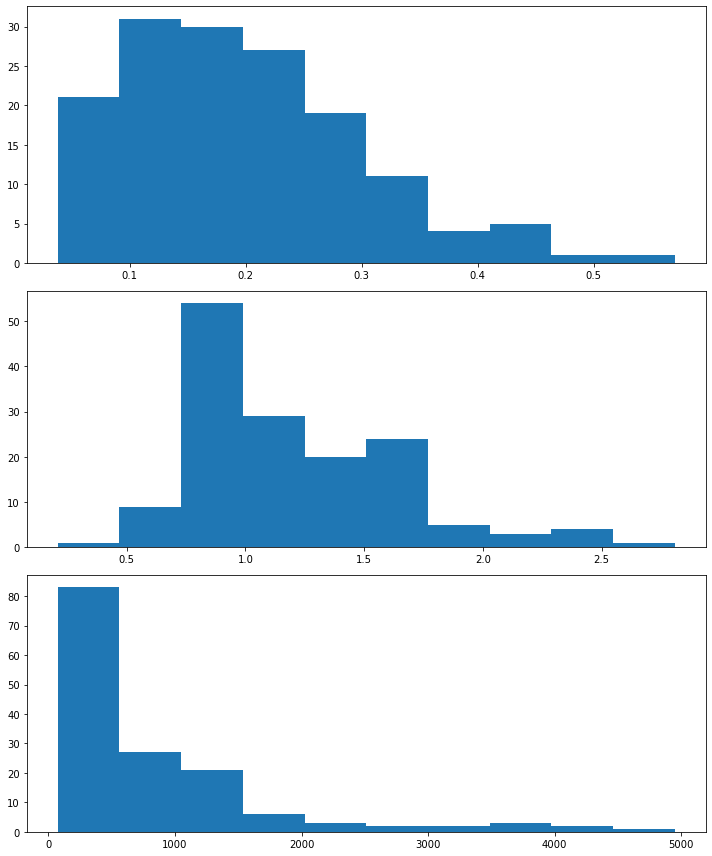

In [9]:
#data before standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()


In [10]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,0.195,1.458,611.888297
1,ISIC_0001852,0.126,0.984,445.832646
2,ISIC_0001871,0.259,0.999,1624.312435
3,ISIC_0003462,0.060,0.743,1400.752341
4,ISIC_0003539,0.416,1.058,305.189066
...,...,...,...,...
145,ISIC_0015443,0.099,1.180,1161.386908
146,ISIC_0015445,0.570,2.387,1805.399547
147,ISIC_0015483,0.072,1.445,1965.247062
148,ISIC_0015496,0.201,1.491,4029.837849


In [11]:
for name in ['asymmetry', 'border', 'colour']:
    mean = np.mean(df_evaluations[name])
    sd = np.std(df_evaluations[name])
    for i in range(df_evaluations.shape[0]):
        df_evaluations.at[i, name] = (df_evaluations.at[i, name] - mean) / sd

In [12]:
df_evaluations

,image_id,asymmetry,border,colour
0,ISIC_0001769,-0.023781,0.578983,-0.238777
1,ISIC_0001852,-0.709402,-0.476142,-0.421655
2,ISIC_0001871,0.612156,-0.442752,0.876211
3,ISIC_0003462,-1.365212,-1.012609,0.630003
4,ISIC_0003539,2.172190,-0.311418,-0.576546
...,...,...,...,...
145,ISIC_0015443,-0.977688,-0.039845,0.366389
146,ISIC_0015445,3.702415,2.646940,1.075643
147,ISIC_0015483,-1.245974,0.550045,1.251684
148,ISIC_0015496,0.035838,0.652441,3.525427


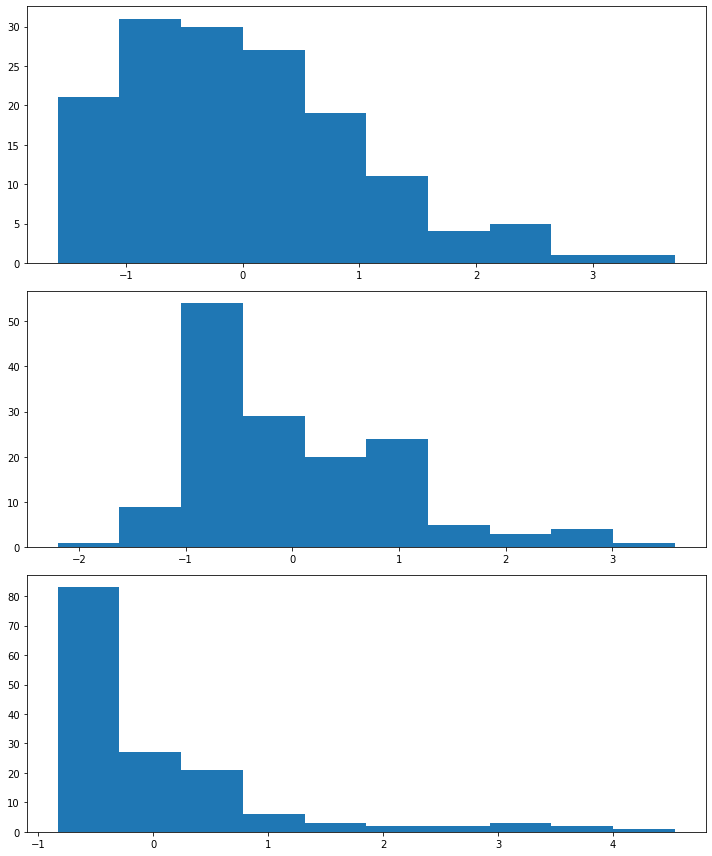

In [13]:
#data after standarisation
fig, axs = plt.subplots(3,figsize=(10,12))
axs[0].hist(df_evaluations['asymmetry'])
axs[1].hist(df_evaluations['border'])
axs[2].hist(df_evaluations['colour'])
fig.tight_layout()

In [14]:
##Loading data#

In [15]:
df = df_conditions.drop('seborrheic_keratosis', axis=1).merge(df_evaluations, on='image_id').drop('image_id', axis=1)
print(df.head())

   melanoma  asymmetry    border    colour
0       0.0  -0.023781  0.578983 -0.238777
1       0.0  -0.709402 -0.476142 -0.421655
2       0.0   0.612156 -0.442752  0.876211
3       0.0  -1.365212 -1.012609  0.630003
4       0.0   2.172190 -0.311418 -0.576546


In [16]:
# Split dataset to select feature and evaluate the classifier
x = df[['asymmetry', 'border', 'colour']]
y = df['melanoma']

# X_train and y_train used for training, X_val and y_val are for predicting and validating the ML model
x_train, x_val, y_train, y_val = train_test_split(
        x, y, stratify=y, test_size=0.4, random_state=0)
sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(x_train, y_train)

Text(0, 0.5, 'Accuracy (%)')

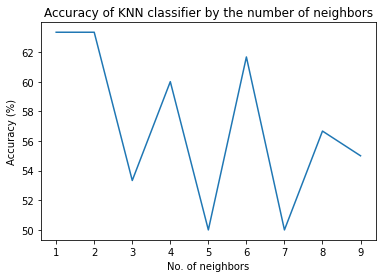

In [30]:
accuracy = [None]
sens = [None]
spec = [None]

# TODO

for n_neighbors in range(1, 10):
    # Train a classifier
    knn = KNeighborsClassifier(n_neighbors) # other hyperparameters possible
    knn_trained = knn.fit(x_train, y_train)
    y_val_knn = knn_trained.predict(x_val)
    # Accuracy - often used in ML but not suitable for medical imaging in general
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_knn).ravel()
    accuracy.append(round(np.sum(y_val_knn == y_val) / np.size(y_val) * 100, 4))
    sens.append(round(sensitivity(tp, fn), 4))
    spec.append(round(specificity(tn, fp), 4))
    '''
    x_min, x_max = x_val['asymmetry'].min() - 1, x_val['asymmetry'].max() + 1
    y_min, y_max = x_val['border'].min() - 1, x_val['border'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
    clf =  KNeighborsClassifier(n_neighbors)
    clf.fit(x_val, y_val)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z)
    sns.scatterplot(x=x_val['asymmetry'], y=x_val['border'], hue=y_val)
    #knn_vis(x_val, knn_trained)
    '''
    
accuracy

plt.plot(range(1, 10), accuracy[1:])
plt.title('Accuracy of KNN classifier by the number of neighbors')
plt.xlabel('No. of neighbors')
plt.ylabel('Accuracy (%)');

# KNN Visualization

In [18]:
'''def knn_vis(x_val, knn_trained):
    h = .02
    cmap_light = ListedColormap(['orange', 'cornflowerblue'])
    cmap_bold = ['darkorange', 'darkblue']
    x_min, x_max = x_val['asymmetry'].min() - 1, x_val['asymmetry'].max() + 1
    y_min, y_max = x_val['border'].min() - 1, x_val['border'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = knn_trained.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
'''

'def knn_vis(x_val, knn_trained):\n    h = .02\n    cmap_light = ListedColormap([\'orange\', \'cornflowerblue\'])\n    cmap_bold = [\'darkorange\', \'darkblue\']\n    x_min, x_max = x_val[\'asymmetry\'].min() - 1, x_val[\'asymmetry\'].max() + 1\n    y_min, y_max = x_val[\'border\'].min() - 1, x_val[\'border\'].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n    Z = knn_trained.predict(np.c_[xx.ravel(), yy.ravel()])\n    \n    Z = Z.reshape(xx.shape)\n    plt.figure(figsize=(8, 6))\n    plt.contourf(xx, yy, Z, cmap=cmap_light)\n\n    # Plot also the training points\n    sns.scatterplot(\n        x=X[:, 0],\n        y=X[:, 1],\n        hue=iris.target_names[y],\n        palette=cmap_bold,\n        alpha=1.0,\n        edgecolor="black",\n    )\n    plt.xlim(xx.min(), xx.max())\n    plt.ylim(yy.min(), yy.max())\n    plt.title(\n        "3-Class classification (k = %i, weights = \'%s\')" % (n_neighbors, weights)\n    )\n    plt.xlabel(iris.featur

# Scatters

In [19]:
k = pd.read_csv("ManualDataAnalysis.csv")
name = k[0:51]
asymmetry = name.loc[:,"Asymmetry"]
border = name.loc[:,"Border"]
Color = name.loc[:,"Color"]
Filename = name.loc[:,"Filename"]
x = range(1,52)


FileNotFoundError: [Errno 2] No such file or directory: 'ManualDataAnalysis.csv'

In [ ]:
plt.figure(figsize=(12, 12), dpi=100)

plt.subplot(2,3,1)
plt.scatter(x,asymmetry,)
plt.title("Asymetry")

plt.subplot(2,3,2)
plt.scatter(x, border)
plt.title("Border")

plt.subplot(2,3,3)
plt.scatter(x, Color)
plt.title("Color")

plt.suptitle("Manual Analysis")

